In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import trange

import tensorflow_utils as tf_utils
import os

random_seed = 123
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True
sess = tf.Session(config=run_config)

save_path = os.path.join('img', 'gan_with_reconstruction_loss')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [2]:
def generate_data(num_mode, except_num, radius=2, center=(0, 0), sigma=0.1, num_data_per_class=100000, name=None):
    total_data = {}
    
    t = np.linspace(0, 2*np.pi, 13)
    x = np.cos(t) * radius + center[0]
    y = np.sin(t) * radius + center[1]
    
    # draw two circles-like lines
    plt.figure()
    plt.plot(x, y)
    
    modes = np.vstack([x, y]).T
    
    for idx, mode in enumerate(modes[except_num:]):
        x = np.random.normal(mode[0], sigma, num_data_per_class)
        y = np.random.normal(mode[1], sigma, num_data_per_class)
        total_data[idx] = np.vstack([x, y]).T
        plt.plot(x, y)
        
    all_points = np.vstack([values for values in total_data.values()])
    data_x, data_y = all_points[:, 0], all_points[:, 1]
    
    plt.savefig(os.path.join(save_path, '{}.png'.format(name)), bbox_inches='tight')

    return total_data, all_points

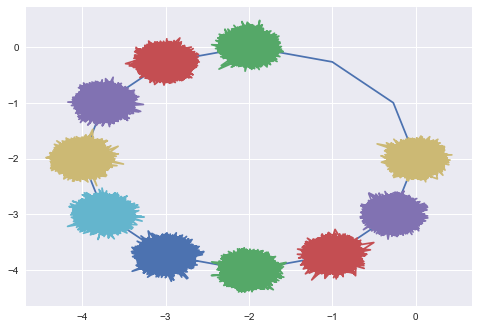

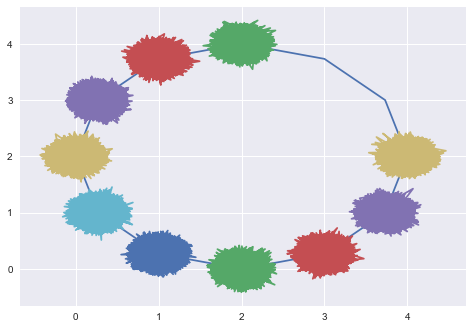

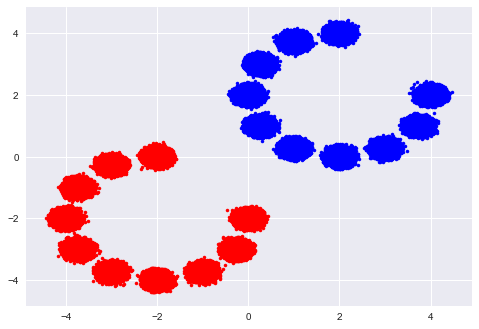

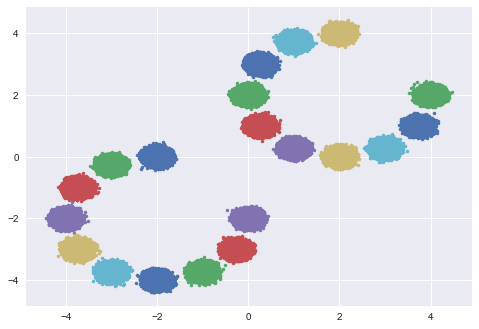

In [3]:
A_data_with_class, A_data = generate_data(13, 3, radius=2, center=(-2, -2), name='A_data')
B_data_with_class, B_data = generate_data(13, 3, radius=2, center=(2, 2), name='B_data')

A_train_np, A_test_np = train_test_split(A_data, test_size=0.33, random_state=random_seed)
B_train_np, B_test_np = train_test_split(B_data, test_size=0.33, random_state=random_seed)

A_train_np, A_test_np = A_train_np.astype(np.float32), A_test_np.astype(np.float32)
B_train_np, B_test_np = B_train_np.astype(np.float32), B_test_np.astype(np.float32)

def plot(data, color):
    plt.plot(data[:, 0], data[:, 1], color)
    
plt.figure()
plot(A_data, 'r.')  # (-2, -2)
plot(B_data, 'b.')  # (2, 2)
plt.savefig(os.path.join(save_path, 'two_modes.png'), bbox_inches='tight')

def plot_with_class(data_with_class):
    for key, value in data_with_class.items():
        plot(value, '.')

plt.figure()
plot_with_class(A_data_with_class)  # (-2, -2)
plot_with_class(B_data_with_class)  # (2, 2)
plt.savefig(os.path.join(save_path, 'two_modes_with_class'), bbox_inches='tight')

In [4]:
print('A_train_np shape: {}'.format(A_train_np.shape))
print('A_test_np shape: {}'.format(A_test_np.shape))
print('B_train_np shape: {}'.format(B_train_np.shape))
print('B_test_np shape: {}'.format(B_test_np.shape))

print('A_train_np dtype: {}'.format(A_train_np.dtype))
print('A_test_np dtype: {}'.format(A_test_np.dtype))
print('B_train_np dtype: {}'.format(B_train_np.dtype))
print('B_test_np dtype: {}'.format(B_test_np.dtype))

A_train_np shape: (670000, 2)
A_test_np shape: (330000, 2)
B_train_np shape: (670000, 2)
B_test_np shape: (330000, 2)
A_train_np dtype: float32
A_test_np dtype: float32
B_train_np dtype: float32
B_test_np dtype: float32


In [5]:
# dataset loader
class DataLoader:
    def __init__(self, data):
        self.data = data
        
    def next_batch(self, batch_size=4):
        random_idx = np.random.randint(self.data.shape[0], size=batch_size)
        batch_data = self.data[random_idx, :]
        return batch_data

A_train_loader = DataLoader(A_train_np)
A_test_loader = DataLoader(A_test_np)

B_train_loader = DataLoader(B_train_np)
B_test_loader = DataLoader(B_test_np)

In [ ]:
class Generator(object):
    def __init__(self, name, output_size, hidden_dims):
        self.name = name
        self.output_size = output_size
        self.hidden_dims = hidden_dims
        self.reuse = False
        
    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=self.reuse):
            # tf_utils.print_activations(x)
            
            input_data = x
            for idx, hidden_dim in enumerate(self.hidden_dims):
                output = tf_utils.linear(input_data, hidden_dim, name='fc_{}'.format(idx))
                output = tf_utils.relu(output, name='relu_{}'.format(idx))
                input_data = output
                
            output = tf_utils.linear(output, self.output_size, name='fc_last')
            
            # set reuse=True for next call
            self.reuse = True
            self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)
            
            return output
        
class Discriminator(object):
    def __init__(self, name, output_size, hidden_dims):
        self.name = name
        self.output_size = output_size
        self.hidden_dims = hidden_dims
        self.reuse = False
        
    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=self.reuse):
            # tf_utils.print_activations(x)

            input_data = x
            for idx, hidden_dim in enumerate(self.hidden_dims):
                output = tf_utils.linear(input_data, hidden_dim, name='fc_{}'.format(idx))
                output = tf_utils.relu(output, name='relu_{}'.format(idx))
                input_data = output
                
            output = tf_utils.linear(output, self.output_size, name='fc_last')
            
            # set reuse=True for next call
            self.reuse = True
            self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)
            
            return output

class DiscoGAN(object):
    def __init__(self, sess):
        self.sess = sess
        # network
        self.hidden_dims = 128
        self.g_num_layer = 3
        self.d_num_layer = 5
        
        # optimizer
        self.lr = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        
        self._build_graph()
        
    def _build_graph(self):
        self.A_ph = tf.placeholder(tf.float32, shape=[None, 2], name='A_ph')
        self.B_ph = tf.placeholder(tf.float32, shape=[None, 2], name='B_ph')

        self.G_AB = Generator('gen_AB', 2, [self.hidden_dims] * self.g_num_layer)
        self.G_BA = Generator('gen_BA', 2, [self.hidden_dims] * self.g_num_layer)
        self.D_B = Discriminator('dis_B', 1, [self.hidden_dims] * self.d_num_layer)
        
        # cycle consistency loss
        self.cycle_loss = self.cycle_consistency_loss(self.A_ph)
        
        # A to B
        self.fake_B = self.G_AB(self.A_ph)
        self.generator_AB_loss = self.generator_loss(self.D_B, self.fake_B)
        self.G_AB_loss = self.generator_AB_loss + self.cycle_loss
        self.G_BA_loss = self.cycle_loss
        self.D_B_loss = self.discriminator_loss(self.D_B, self.B_ph, self.fake_B) 
        
        G_AB_optim = tf.train.AdamOptimizer(
            learning_rate=self.lr, beta1=self.beta1, beta2=self.beta2).minimize(
            self.G_AB_loss, var_list=self.G_AB.variables, name='Adam_G_AB')
        D_B_optim = tf.train.AdamOptimizer(
            learning_rate=self.lr, beta1=self.beta1, beta2=self.beta2).minimize(
            self.D_B_loss, var_list=self.D_B.variables, name='Adam_D_B')
        G_BA_optim = tf.train.AdamOptimizer(
            learning_rate=self.lr, beta1=self.beta1, beta2=self.beta2).minimize(
            self.G_BA_loss, var_list=self.G_BA.variables, name='Adam_G_BA')
        
        self.all_optims = tf.group([G_AB_optim, D_B_optim, G_BA_optim])

    def cycle_consistency_loss(self, A_data):
        loss = tf.losses.mean_squared_error(labels=A_data, predictions=self.G_BA(self.G_AB(A_data)))
        return loss

    def generator_loss(self, dis_obj, fake_data):
        d_logit_fake = dis_obj(fake_data)
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))
        return loss
    
    def discriminator_loss(self, dis_obj, real_data, fake_data):
        d_logit_real = dis_obj(real_data)
        d_logit_fake = dis_obj(fake_data)
    
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_logit_real)))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))
        d_loss = d_loss_real + d_loss_fake
        return d_loss
    
    def train_step(self, A_batch, B_batch):
        _, loss_G_AB, loss_D_B, loss_G_BA = self.sess.run([self.all_optims, self.G_AB_loss, self.D_B_loss, self.G_BA_loss], 
                                                          feed_dict={self.A_ph: A_batch, self.B_ph: B_batch})
        
        return [loss_G_AB, loss_D_B, loss_G_BA]
    
    def test_AB(self, A_batch):
        B_fake = self.sess.run([self.fake_B], feed_dict={self.A_ph: A_batch})
        return B_fake

model = DiscoGAN(sess)
sess.run(tf.global_variables_initializer())

In [ ]:
max_iteration = 5000
batch_size = 200
sample_freq = 50


for idx in trange(max_iteration):
    batch_A, batch_B = A_train_loader.next_batch(batch_size=batch_size), B_train_loader.next_batch(batch_size=batch_size)
    
    loss = model.train_step(batch_A, batch_B)
    
    if np.mod(idx, sample_freq) == 0:
        # print("[{}/{}]\n G_AB_loss: {}\n D_B_loss: {}\n G_BA_loss: {}\n".format(idx, max_iteration, loss[0], loss[1], loss[2]))
        
        plt.figure()
        ax = sns.kdeplot(B_test_np[:1000], cmap="Reds", shape=True, shade_lowest=False)
        plot(B_test_np[:1000], 'k.')
        
        for key, value in A_data_with_class.items():
            data = (value[:1000]).astype(np.float32)
            pred = model.test_AB(data)
 
            plot(np.asarray(pred)[0], '.')
        plt.savefig(os.path.join(save_path, 'GAN_rec_loss_AB_{}'.format(idx)), bbox_inches='tight')    

  0%|                                                                                                                               | 0/5000 [00:00<?, ?it/s]E:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'shape'
  s)
 20%|███████████████████████▍                                                                                             | 999/5000 [00:25<01:23, 48.17it/s]E:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 4399/5000 [01:51<00:13, 44.65it/s]